# Проект: классификация

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
import optuna
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.info()
print("На данном этапе видим только одно поле с пропусками - это 'balance'")

# за основу для вычисления кол-ва пропусков возьмем целевой признак - deposit
count_null_in_balance = df.deposit.shape[0]-df.balance.loc[df.balance.isnull() == False].shape[0]
print("Кол-во пропусков в признаке 'balance' равно: {}".format(count_null_in_balance))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB
На данном этапе видим только одно поле с пропусками - это 'balance'
Кол-во пропусков в признаке 'ba

### Задание 2

In [4]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df.job.value_counts()

#Как видно из таблицы ниже, есть категория 'unknown' в признаке 'job'

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [5]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df.balance = df.balance.str.replace("$","").str.replace(" ","").str.replace(",",".").astype(float)
# посчитаем среднее значение по признаку:
round(df.balance.mean(),3)

1529.129

### Задание 4

In [6]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df.balance = df.balance.fillna(df.balance.median())
round(df.balance.mean(),3)

1526.936

### Задание 5

In [7]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения

# модальные значения - это наиболее часто встречающиеся значения. Определим их через метод value_counts().
df.education = df.education.replace('unknown',df.education.value_counts().index[0])
df.job = df.job.replace('unknown',df.job.value_counts().index[0])
round(df.balance.loc[(df.job==df.job.value_counts().index[0]) & (df.education==df.education.value_counts().index[0])].mean(),3)

1598.883

### Задание 6

In [8]:
# удалите все выбросы для признака balance

from collections import Counter

def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers

print("Количество строк до удаления выбросов - {}".format(df.shape[0]))
outliners_to_drop = detect_outliers(df,0,['balance'])
df = df.drop(outliners_to_drop)
print("Количество строк после удаления выбросов - {}".format(df.shape[0]))

Количество строк до удаления выбросов - 11162
Количество строк после удаления выбросов - 10105


## Часть 2:  Разведывательный анализ

### Задание 1

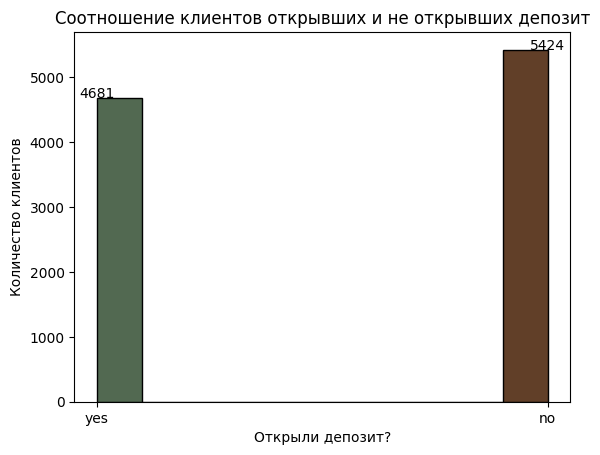

In [9]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
import random
import string

fig, ax = plt.subplots()
# Plot a histogram with random data
N, bins, patches = ax.hist(df.deposit, edgecolor='black', linewidth=1)

# Random facecolor for each bar
for i in range(len(N)):
   patches[i].set_facecolor("#" + ''.join(random.choices("ABCDEF" + string.digits, k=6)))

# Add value labels
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
# calling the function to add value labels
addlabels(df.deposit.value_counts().sort_values().index, df.deposit.value_counts().sort_values().values)

# Add text to histogram
plt.xlabel('Открыли депозит?')
plt.ylabel('Количество клиентов')
plt.title('Соотношение клиентов открывших и не открывших депозит')

# Display the plot
plt.show()

### Задания 2 и 3

Максимальный возраст клиентов: 95 л.
Минимальная продолжительность контакта: 2 сек.


Выявлено в ходе анализа: Чем больше возраст - тем неохотнее говорят по телефону, тем в меньшем кол-ве компании участвуют, отрицательный баланс не присутствует у людей свыше 50 лет, на молодых людей больше влияет продолжительность разговора, и они принимают участие в большом кол-ве акций.


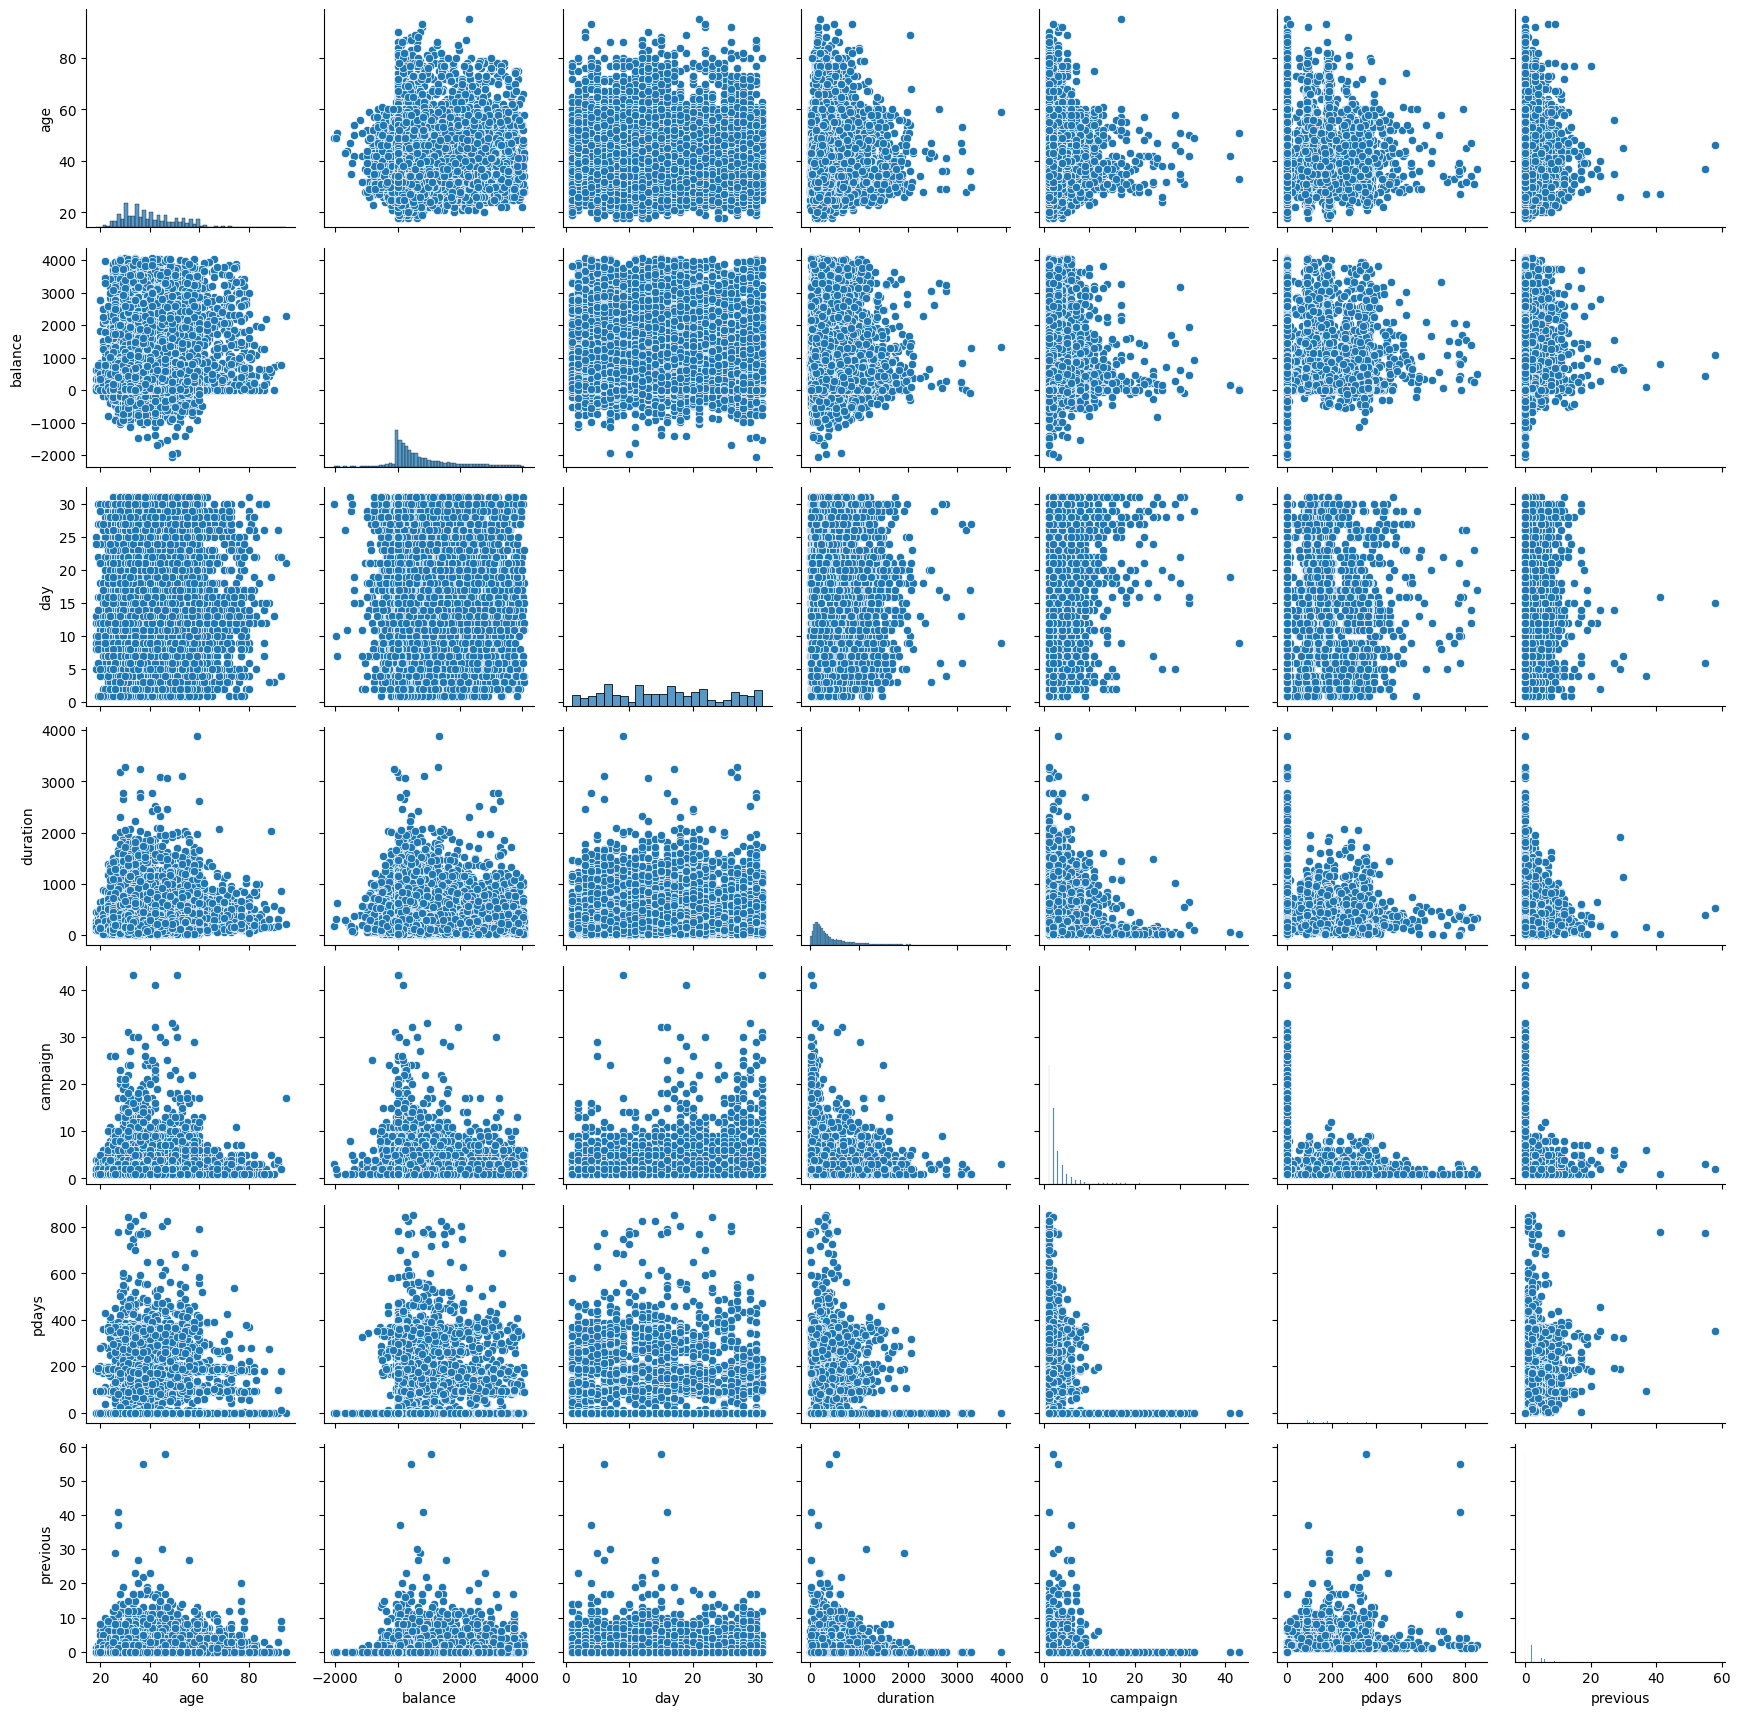

In [10]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат

import pandas_profiling

df_numeric = df.select_dtypes(include=['float64', 'int64'])

#df_numeric.describe()
#df_numeric.profile_report()


# предварительные выводы:
print("Максимальный возраст клиентов: {} л.".format(df_numeric.age.max()))
print("Минимальная продолжительность контакта: {} сек.".format(df_numeric.duration.min()))
print('\n')

# for column in df_numeric:
#     #sns.histplot(ax=axes[i], x=df_numeric[column].values)
#     sns.histplot(x=df[column])
#     sns.boxplot(x=df[column])
#     plt.show()

g = sns.PairGrid(df_numeric)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

print("Выявлено в ходе анализа: Чем больше возраст - тем неохотнее говорят по телефону, тем в меньшем кол-ве компании участвуют, отрицательный баланс не присутствует у людей свыше 50 лет, \
на молодых людей больше влияет продолжительность разговора, и они принимают участие в большом кол-ве акций.")

### Задания 4 и 5

In [11]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
df_objects = df.select_dtypes(include=['object'])
#постройте визуализации, иллюстрирующие результаты

print("Исходя из анализа по профайлу, видно: \n 1) Поле poutcome - бесполезно для обучения, но полезно для анализа, его можно исключить в итоге;\n 2) Поле job - сильно скоррелировано с образованием, но оставим оба на данном этапе;\n \
3) В поле job можно сгруппировать на три уровня: не трудоустроенный, синий воротничек, белый воротничек, самозанятый; \n 4) Поле семейный статус можно объединить в две категории: одинок, в браке.")
df_objects.profile_report()

Исходя из анализа по профайлу, видно: 
 1) Поле poutcome - бесполезно для обучения, но полезно для анализа, его можно исключить в итоге;
 2) Поле job - сильно скоррелировано с образованием, но оставим оба на данном этапе;
 3) В поле job можно сгруппировать на три уровня: не трудоустроенный, синий воротничек, белый воротничек, самозанятый; 
 4) Поле семейный статус можно объединить в две категории: одинок, в браке.


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Задание 6

In [12]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код

#pd.pivot_table(data=df[['poutcome']], index=df.previous, columns=df.poutcome, aggfunc='count')

df2 = df.deposit.groupby(df.poutcome).value_counts()
#df.poutcome.value_counts()

### Задание 7

In [13]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
df2 = df.deposit.groupby(df.month).value_counts()
df3 = pd.DataFrame(df2)
df3.columns = ['v']
df3 = df3.reset_index()
df4 = df3.pivot(index='month',columns='deposit',values='v')
df4['percentage_of_fail'] = round(df4.no/(df4.no + df4.yes),2)
df4.sort_values(by='percentage_of_fail',ascending=False).head(1)

deposit,no,yes,percentage_of_fail
month,,,
may,1776,841,0.68


### Задание 8

In [14]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def set_group(series):
  res_ser = pd.Series() 
  if series <=30:
    res_ser = 'under 30'
  elif series> 30 and series<=40:
    res_ser = '30-40'
  elif series> 40 and series<=50:
    res_ser = '40-50'
  elif series> 50 and series<=60:
    res_ser = '50-60'
  elif series> 60 and series<=100:
    res_ser = 'above 60'
  return res_ser

df['age_group'] = df.age.apply(set_group)

df2 = df[['age_group','deposit']]

df3 = pd.DataFrame(df2.deposit.groupby(df2['age_group']).value_counts())
df3.columns = ['v']
df3 = df3.reset_index()
df4 = df3.pivot(index='age_group',columns='deposit',values='v')
df4['percentage_of_succsess'] = round(df4.yes/(df4.no + df4.yes),2)

display(df4.sort_values(by='percentage_of_succsess',ascending=False).head(2))

deposit,no,yes,percentage_of_succsess
age_group,,,
above 60,97,416,0.81
under 30,819,1051,0.56


### Задания 9 и 10

<AxesSubplot: xlabel='marital', ylabel='Count'>

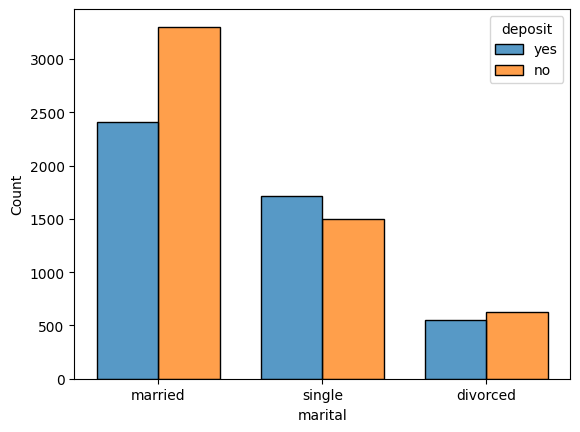

In [15]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.histplot(df, x='marital', hue='deposit',
             multiple='dodge', shrink=.75, bins=20)


<AxesSubplot: xlabel='education', ylabel='Count'>

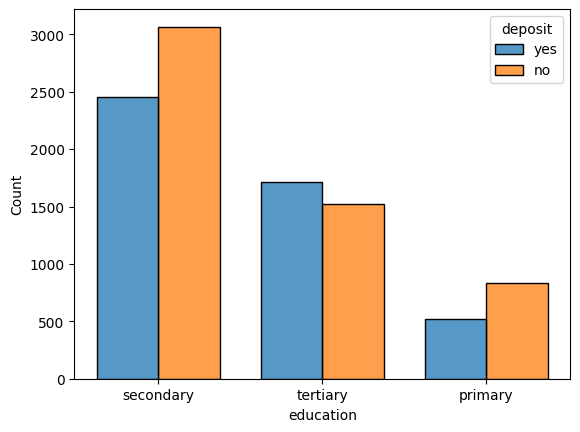

In [16]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.histplot(df, x='education', hue='deposit',
             multiple='dodge', shrink=.75, bins=20)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'admin.'),
  Text(1, 0, 'technician'),
  Text(2, 0, 'services'),
  Text(3, 0, 'management'),
  Text(4, 0, 'retired'),
  Text(5, 0, 'blue-collar'),
  Text(6, 0, 'unemployed'),
  Text(7, 0, 'entrepreneur'),
  Text(8, 0, 'housemaid'),
  Text(9, 0, 'self-employed'),
  Text(10, 0, 'student')])

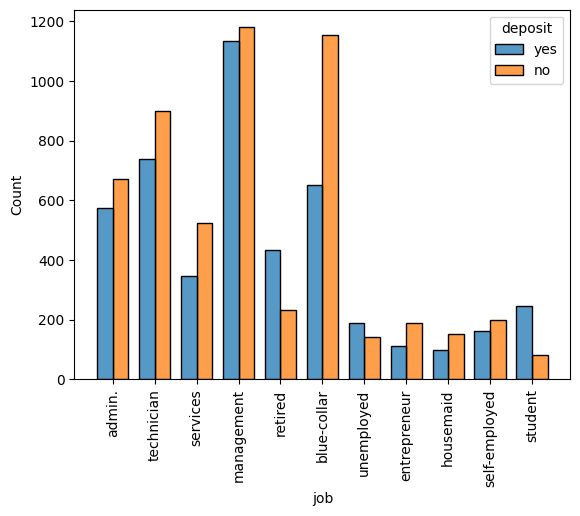

In [17]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
sns.histplot(df, x='job', hue='deposit',
             multiple='dodge', shrink=.75, bins=20)
plt.xticks(rotation=90)

### Задание 11

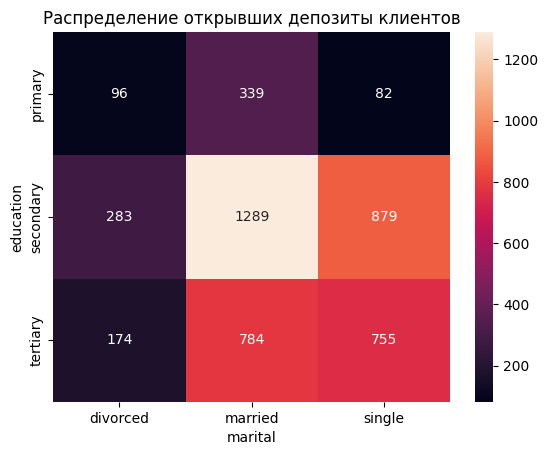

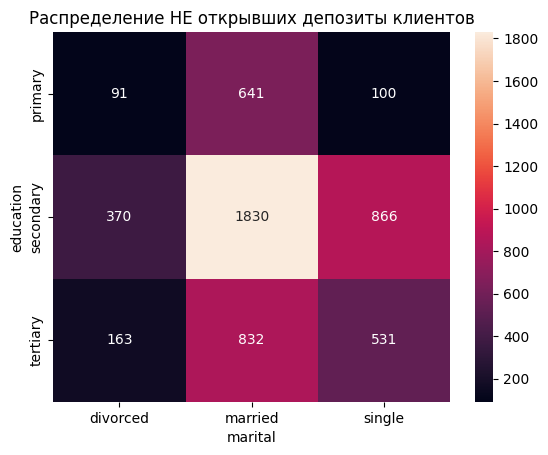

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


In [18]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df2 = df.loc[df.deposit == 'yes']
df3 = df.loc[df.deposit == 'no']
df2 = df2.pivot_table(values='age',index='education', columns='marital', aggfunc='count')

sns.heatmap(df2, annot=True, fmt=".0f", )
plt.title("Распределение открывших депозиты клиентов")
plt.show()

df3 = df3.pivot_table(values='age',index='education', columns='marital', aggfunc='count')

sns.heatmap(df3, annot=True, fmt=".0f", )
plt.title("Распределение НЕ открывших депозиты клиентов")
plt.show()

display(df2)

## Часть 3: преобразование данных

### Задание 1

In [19]:
# преобразуйте уровни образования
LE = LabelEncoder()
df['education'] = LE.fit_transform(df['education'])
df.education.sum()

df.age_group = LE.fit_transform(df.age_group)

### Задания 2 и 3

In [20]:
# преобразуйте бинарные переменные в представление из нулей и единиц
def binarization(ser):
    return ser.apply(lambda x: 1 if x=='yes' else 0)

df.deposit = binarization(df.deposit)
df.default = binarization(df.default)
df.housing =  binarization(df.housing)
df.loan =  binarization(df.loan)
print(f"Стандартное отклонение полученного показателя депозиты: {round(df.deposit.std(),3)}")
print(f"Сумма трех обработанных булевских показателей: {round(df.default.mean() + df.housing.mean() + df.loan.mean(),3)}")

Стандартное отклонение полученного показателя депозиты: 0.499
Сумма трех обработанных булевских показателей: 0.635


### Задание 4

In [21]:
# создайте дамми-переменные
df2 = pd.get_dummies(df[['job', 'marital', 'contact', 'month', 'poutcome']])
#df = df.drop(['job', 'marital', 'contact', 'month', 'poutcome'], axis=1)
df = pd.merge(df, df2, left_index=True, right_index=True)
print(f"Количество столбцов = {df.shape[1]-1}")

Количество столбцов = 50


### Задания 5 и 6

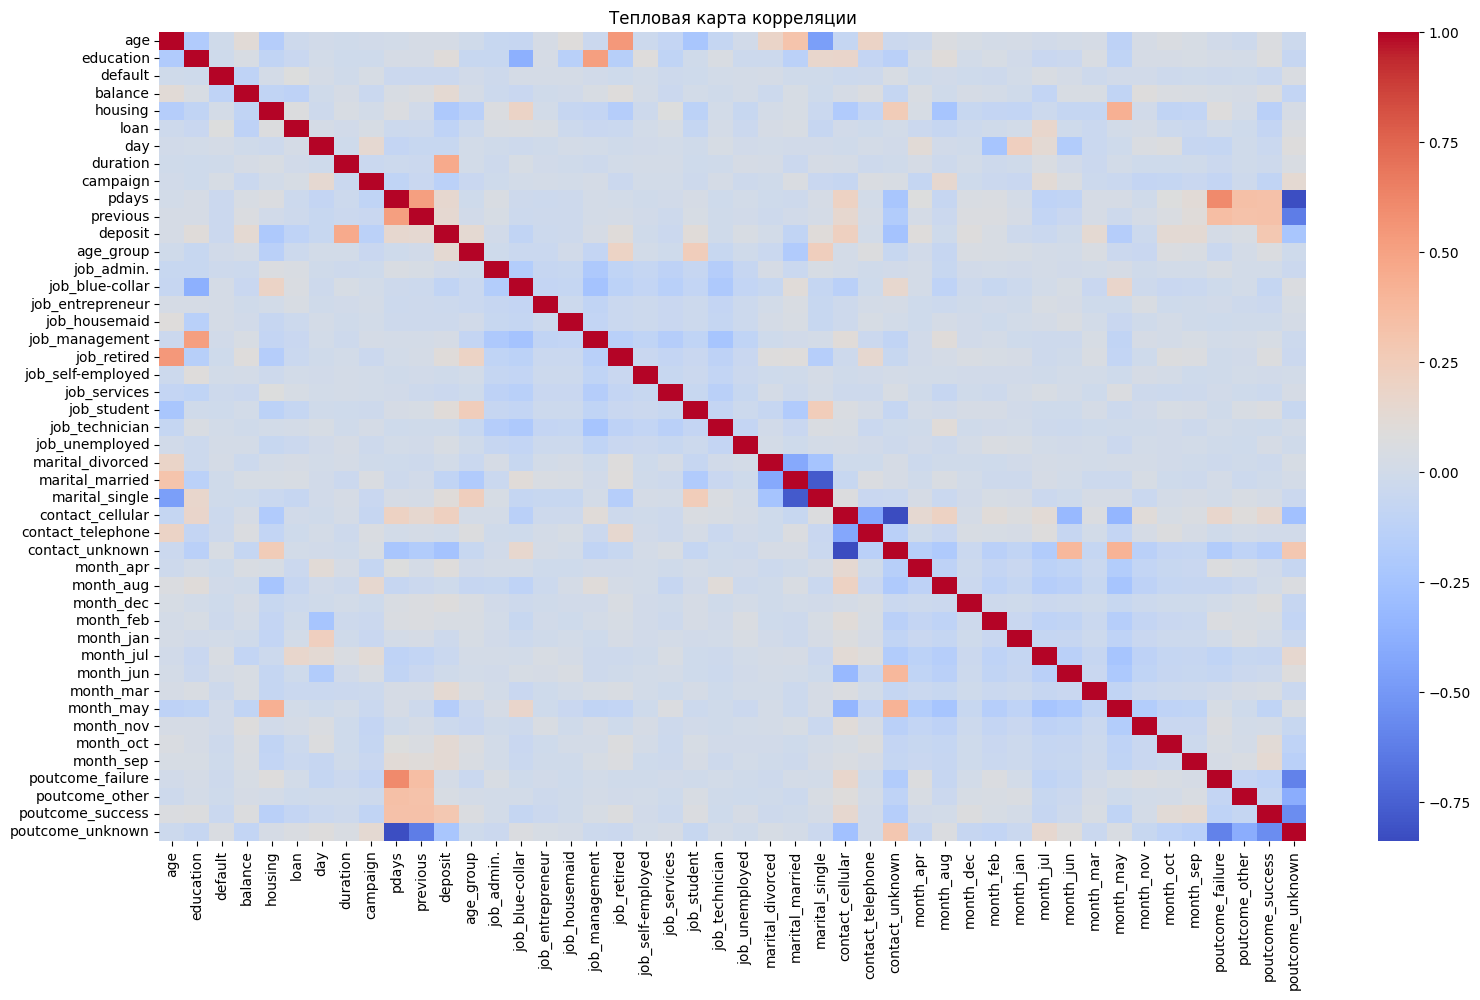

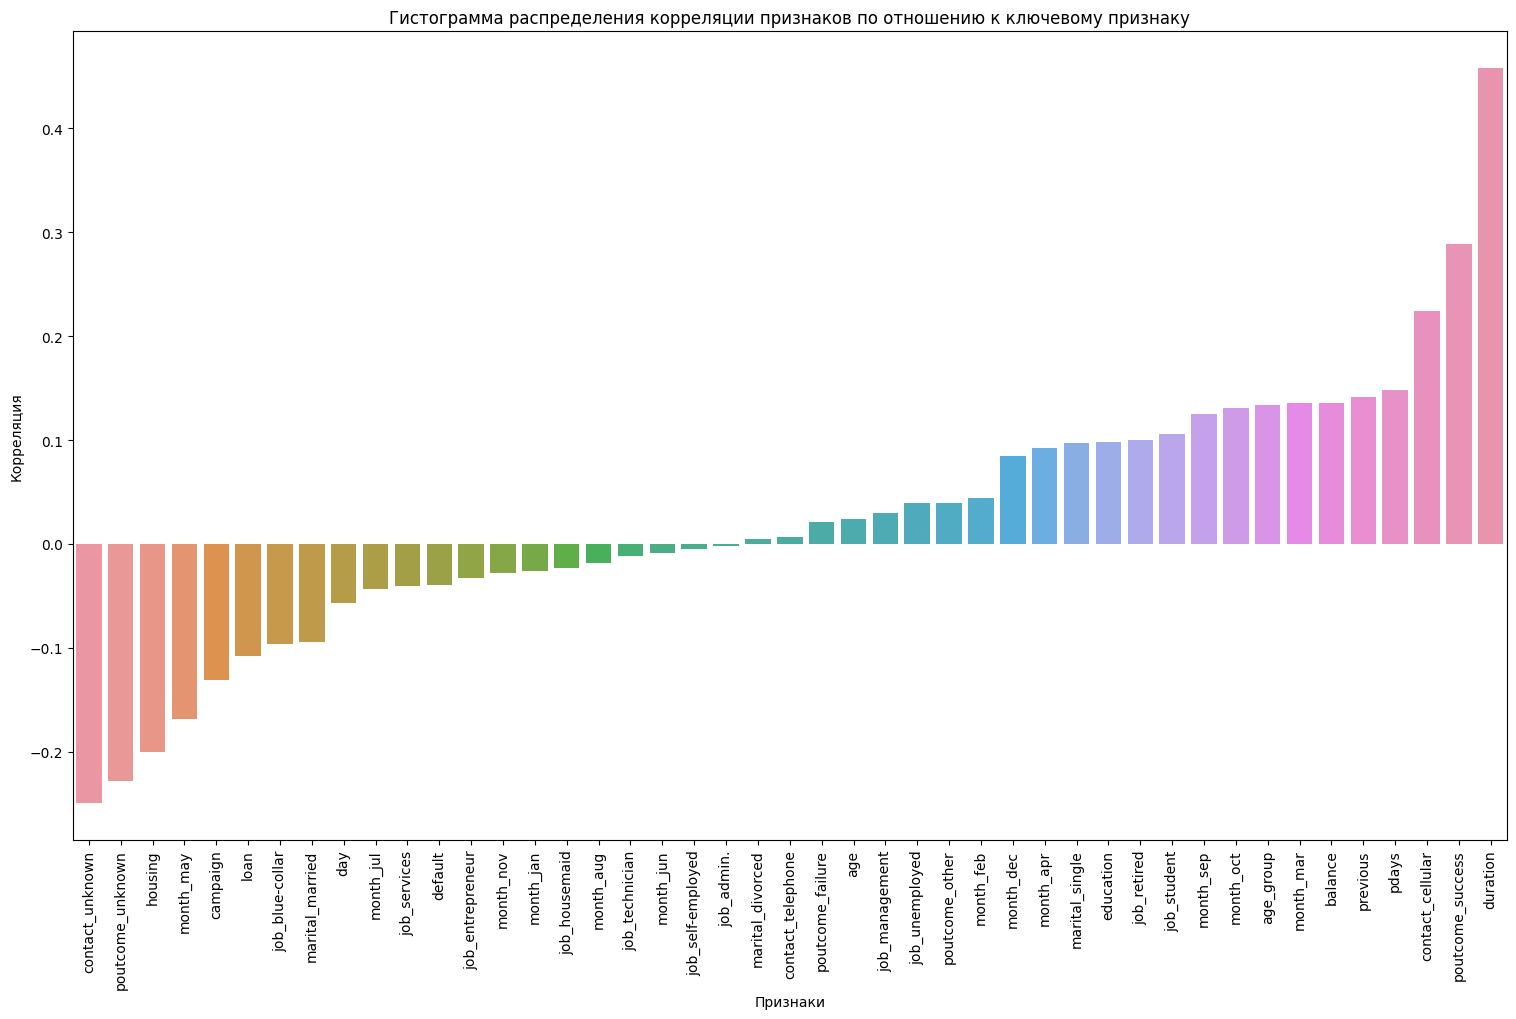

In [22]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
import matplotlib.pyplot


#df_corr = df.corr()

#df_corr.sort_values(by='deposit', inplace=True)
#df_corr
# df_for_corr_headers = list(df.columns.values)
# df_for_corr_headers.remove('deposit')
# df_for_corr_headers


sns.heatmap(df.corr(), annot=False, cmap='coolwarm', xticklabels=True, yticklabels=True)
plt.title("Тепловая карта корреляции")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

df_key = df.corr()['deposit'].drop('deposit')
g = sns.barplot(df_key, x=df_key.index, y=df_key.values, estimator='sum')
plt.xticks(rotation=90)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

g.set_xticklabels(df_key.sort_values().index)
g.set(xlabel='Признаки', ylabel='Корреляция', title='Гистограмма распределения корреляции признаков по отношению к ключевому признаку')
plt.show()

### Задания 7 и 8

In [23]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [24]:
# рассчитайте необходимые показатели
display(X_test.shape[0])
display(round(y_test.mean(),2))

3335

0.46

### Задание 9

In [25]:
X_train = X_train.drop(['job','marital','contact','poutcome', 'month'], axis=1)
X_test = X_test.drop(['job','marital','contact','poutcome', 'month'], axis=1)

In [26]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)
selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

### Задание 10

In [27]:
# нормализуйте данные с помощью minmaxsxaler
col_names = selector.get_feature_names_out()
scaler = MinMaxScaler()

X_train_scaled = X_train[col_names]
X_train_scaled = scaler.fit_transform(X_train_scaled.values)

X_test_scaled = X_test[col_names]
X_test_scaled = scaler.fit_transform(X_test_scaled.values)

first_column = X_train_scaled[:, 0]
round(first_column.mean(),2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [28]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

y_predict = log_reg.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_predict)))

Accuracy: 0.82


### Задания 2,3,4

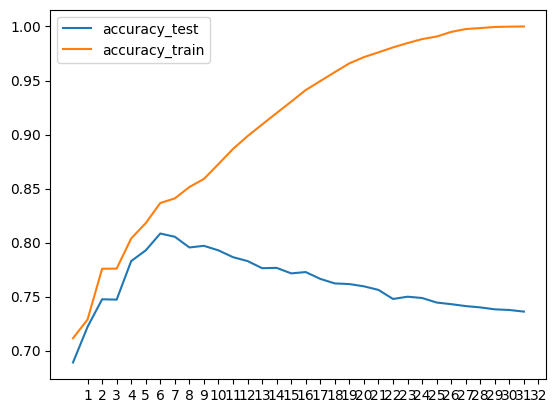

Глубина дерева, которая дает максимальный показатель accuracy = 6.
При этом accuracy = 0.81.


In [29]:
# обучите решающие деревья, настройте максимальную глубину
dict_result = {'max_depth': [], 'accuracy_test': [], 'accuracy_train': []}


for i in range(1, 33):
    dt_clf = tree.DecisionTreeClassifier(
        criterion='entropy',
        random_state= 42,
        max_depth=i
    )

    dt_clf.fit(X_train_scaled, y_train)
    y_predict_train = dt_clf.predict(X_train_scaled)
    y_predict_test = dt_clf.predict(X_test_scaled)

    dict_result['max_depth'].append(i)
    dict_result['accuracy_test'].append(metrics.accuracy_score(y_test, y_predict_test))
    dict_result['accuracy_train'].append(metrics.accuracy_score(y_train, y_predict_train))

df_res = pd.DataFrame(dict_result)
df_res[['accuracy_test', 'accuracy_train' ]].plot(xticks=df_res.max_depth)
plt.show()
print("Глубина дерева, которая дает максимальный показатель accuracy = {:.0f}.".format(df_res.iloc[df_res.accuracy_test.values == df_res.accuracy_test.max()].iloc[:, 0].values[0]-1))
print("При этом accuracy = {:.2f}.".format(df_res.iloc[df_res.accuracy_test.values == df_res.accuracy_test.max()].iloc[:, 1].values[0]))


In [30]:
# Итоговый вариант дерева решений:
dtree_clf = tree.DecisionTreeClassifier(
        criterion='entropy',
        random_state= 42,
        max_depth=6
    )

### Задание 5

In [31]:
# подберите оптимальные параметры с помощью gridsearch
param_grid = {'min_samples_split': [2, 5, 7, 10] ,
                  'max_depth':[3,5,7] 
                  }

grid_search = GridSearchCV(tree.DecisionTreeClassifier(
        criterion='entropy',
        random_state= 42,
    ),param_grid=param_grid, n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

y_test_pred = grid_search.predict(X_test_scaled)
print("Наилучшие значения параметров: {}".format(grid_search.best_params_))
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения параметров: {'max_depth': 7, 'min_samples_split': 10}
f1_score на тестовом наборе: 0.809


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [32]:
# обучите на ваших данных случайный лес
rf_clf = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
)

rf_clf.fit(X_train_scaled,y_train)
y_pred = rf_clf.predict(X_test_scaled)

#Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1790
           1       0.76      0.89      0.82      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



### Задания 2 и 3

In [33]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gr_boosting = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)

gr_boosting.fit(X_train_scaled, y_train)
y_pred = gr_boosting.predict(X_test_scaled)

print(metrics.f1_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

0.8174174174174172
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1790
           1       0.76      0.88      0.82      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



### Задание 4

In [34]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [('lr',log_reg),('dt', dtree_clf), ('gb', gr_boosting)]
reg = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(
                                          random_state=42)
)

reg.fit(X_train_scaled, y_train)
y_pred = reg.predict(X_test_scaled)

print(f"Значение метрики precision: {metrics.precision_score(y_test, y_pred)}")
print(metrics.classification_report(y_test, y_pred))


Значение метрики precision: 0.7701149425287356
              precision    recall  f1-score   support

           0       0.87      0.78      0.82      1790
           1       0.77      0.87      0.82      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

In [35]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
f_metrics, _ = f_classif(X_test_scaled, y_test)


print(col_names)
print(f_metrics)

['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous' 'age_group'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']
[ 76.87879527 121.88315326 840.53080746  38.77489391  77.20845292
  53.22953054  54.48445534 182.91945237 243.02552954  74.52863631
 111.23907618  50.15176886  34.9242153  289.55873254 182.48093859]


### Задания 6,7,8

In [39]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
random_state = 42
def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_test, model.predict(X_test_scaled))

  return score

In [42]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=100)

[I 2023-04-12 08:40:00,405] A new study created in memory with name: RandomForestClassifier
[I 2023-04-12 08:40:01,719] Trial 0 finished with value: 0.821227394011266 and parameters: {'n_estimators': 199, 'max_depth': 28, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.821227394011266.
[I 2023-04-12 08:40:02,435] Trial 1 finished with value: 0.8112305854241338 and parameters: {'n_estimators': 136, 'max_depth': 29, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.821227394011266.
[I 2023-04-12 08:40:03,285] Trial 2 finished with value: 0.8193701723113488 and parameters: {'n_estimators': 143, 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.821227394011266.
[I 2023-04-12 08:40:04,135] Trial 3 finished with value: 0.8173134328358209 and parameters: {'n_estimators': 130, 'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.821227394011266.
[I 2023-04-12 08:40:04,761] Trial 4 finished with value: 0.8189680882791531 and parameters: {'n_esti

CPU times: total: 1min 24s
Wall time: 1min 29s


In [43]:
# обучите на ваших данных случайный лес, берем значение гиперпараметров из Optuna
rf_clf = ensemble.RandomForestClassifier(
    n_estimators = 188,
    min_samples_leaf = 3,
    max_depth = 27,
    random_state = 42
)

rf_clf.fit(X_train_scaled,y_train)
y_pred = rf_clf.predict(X_test_scaled)

#Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1790
           1       0.76      0.89      0.82      1545

    accuracy                           0.82      3335
   macro avg       0.83      0.83      0.82      3335
weighted avg       0.83      0.82      0.82      3335

